# Import data

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Model
from keras import applications
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Dimensions of our images.
img_width, img_height = 128, 128

# epochs and batch_size
epochs = 100
batch_size = 32

# path to train and validation data
train_data_dir = 'data/train'
valid_data_dir = 'data/valid'
test_data_dir = 'data/test'
# train_data_dir = '/dev/shm/train'
# valid_data_dir = '/dev/shm/valid'

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 68778 images belonging to 360 classes.


In [6]:
valid_generator = datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 14400 images belonging to 360 classes.


In [7]:
test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 3600 images belonging to 360 classes.


In [8]:
n_classes = 360
train_samples = 68778
valid_samples = 14400
test_samples = 3600

# Basic CNN

In [9]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

In [11]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
 - 111s - loss: 5.0317 - acc: 0.0710 - val_loss: 4.0574 - val_acc: 0.1888

Epoch 00001: val_acc improved from -inf to 0.18882, saving model to models/basic_cnn.h5
Epoch 2/100
 - 106s - loss: 3.6503 - acc: 0.2490 - val_loss: 3.0961 - val_acc: 0.3522

Epoch 00002: val_acc improved from 0.18882 to 0.35215, saving model to models/basic_cnn.h5
Epoch 3/100
 - 109s - loss: 3.0506 - acc: 0.3520 - val_loss: 2.7275 - val_acc: 0.4260

Epoch 00003: val_acc improved from 0.35215 to 0.42604, saving model to models/basic_cnn.h5
Epoch 4/100
 - 108s - loss: 2.7583 - acc: 0.4098 - val_loss: 2.5272 - val_acc: 0.4660

Epoch 00004: val_acc improved from 0.42604 to 0.46604, saving model to models/basic_cnn.h5
Epoch 5/100
 - 108s - loss: 2.6445 - acc: 0.4336 - val_loss: 2.4104 - val_acc: 0.4962

Epoch 00005: val_acc improved from 0.46604 to 0.49618, saving model to models/basic_cnn.h5
Epoch 6/100
 - 107s - loss: 2.6206 - acc: 0.4426 - val_loss: 2.6677 - val_acc: 0.4467

Epoch 00006: val_acc did n

In [12]:
model.evaluate_generator(test_generator, test_samples)

[2.7147180433136295, 0.47506625749755893]

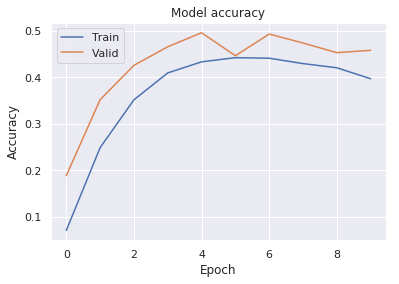

In [14]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Data Augumentation

In [15]:
datagen_augmented = ImageDataGenerator(
        rescale=1. / 255,      
        shear_range=0.2,       
        zoom_range=0.2,        
        horizontal_flip=True)  

In [16]:
train_generator_augmented = datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 68778 images belonging to 360 classes.


In [17]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/data_augmentation.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
 - 240s - loss: 3.6447 - acc: 0.2640 - val_loss: 3.1485 - val_acc: 0.3583

Epoch 00001: val_acc improved from -inf to 0.35826, saving model to models/data_augmentation.h5
Epoch 2/100
 - 239s - loss: 3.7429 - acc: 0.2485 - val_loss: 3.2608 - val_acc: 0.3346

Epoch 00002: val_acc did not improve from 0.35826
Epoch 3/100
 - 239s - loss: 3.9197 - acc: 0.2230 - val_loss: 3.6206 - val_acc: 0.2874

Epoch 00003: val_acc did not improve from 0.35826
Epoch 4/100
 - 239s - loss: 4.0793 - acc: 0.2039 - val_loss: 3.7304 - val_acc: 0.2662

Epoch 00004: val_acc did not improve from 0.35826
Epoch 5/100
 - 241s - loss: 4.1793 - acc: 0.1888 - val_loss: 3.5464 - val_acc: 0.2894

Epoch 00005: val_acc did not improve from 0.35826
Epoch 6/100
 - 245s - loss: 4.3241 - acc: 0.1703 - val_loss: 4.0424 - val_acc: 0.1888

Epoch 00006: val_acc did not improve from 0.35826
Epoch 00006: early stopping


In [18]:
model.evaluate_generator(valid_generator, valid_samples)

[4.04241034867035, 0.18875]

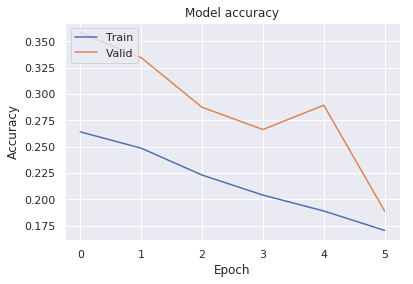

In [19]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# VGG 16 models

In [20]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

In [21]:
bottleneck_features_train = model_vgg.predict_generator(train_generator, np.ceil(train_samples/float(batch_size)))
#np.save(open('/dev/shm/models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [22]:
bottleneck_features_validation = model_vgg.predict_generator(valid_generator, np.ceil(valid_samples/float(batch_size)))
#np.save(open('/dev/shm/models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [23]:
num_classes = len(train_generator.class_indices)

train_data = bottleneck_features_train
train_labels = to_categorical(train_generator.classes[:train_samples], num_classes=num_classes)

validation_data = bottleneck_features_validation
validation_labels = to_categorical(valid_generator.classes[:valid_samples], num_classes=num_classes)

In [24]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

model_top.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [25]:
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 360)               184680    
Total params: 4,379,496
Trainable params: 4,379,496
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model_top.fit(
        train_data,
        train_labels,
        verbose=2,
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpointer, early_stopping],
        validation_data=(validation_data, validation_labels))

Train on 68778 samples, validate on 14400 samples
Epoch 1/100
 - 25s - loss: 5.8901 - acc: 0.0029 - val_loss: 5.8910 - val_acc: 0.0028

Epoch 00001: val_acc improved from -inf to 0.00278, saving model to models/bottleneck_features.h5
Epoch 2/100
 - 25s - loss: 5.8790 - acc: 0.0031 - val_loss: 5.8969 - val_acc: 0.0028

Epoch 00002: val_acc did not improve from 0.00278
Epoch 3/100
 - 25s - loss: 5.8786 - acc: 0.0033 - val_loss: 5.9010 - val_acc: 0.0028

Epoch 00003: val_acc did not improve from 0.00278
Epoch 4/100
 - 25s - loss: 5.8783 - acc: 0.0035 - val_loss: 5.9035 - val_acc: 0.0028

Epoch 00004: val_acc did not improve from 0.00278
Epoch 5/100
 - 25s - loss: 5.8785 - acc: 0.0035 - val_loss: 5.9047 - val_acc: 0.0028

Epoch 00005: val_acc did not improve from 0.00278
Epoch 6/100
 - 25s - loss: 5.8787 - acc: 0.0031 - val_loss: 5.9054 - val_acc: 0.0028

Epoch 00006: val_acc did not improve from 0.00278
Epoch 00006: early stopping


In [27]:
model_top.evaluate(validation_data, validation_labels)

14400/14400 [==============================] - 1s 61us/step


[5.905374737845527, 0.002777777777777778]

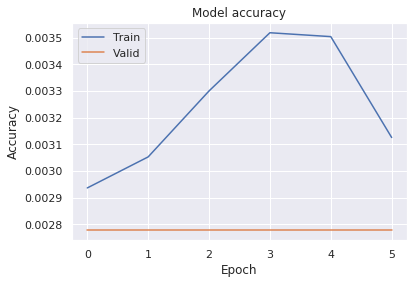

In [28]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Fine Tuning

In [29]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [30]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('models/bottleneck_features.h5')

model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

In [31]:
for layer in model.layers[:15]:
    layer.trainable = False

In [32]:
# Compile the model with a SGD/momentum optimizer and a slow learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

# Training

In [ ]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/finetuning_full.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
 - 549s - loss: 5.8724 - acc: 0.0037 - val_loss: 5.8341 - val_acc: 0.0056

Epoch 00001: val_acc improved from -inf to 0.00562, saving model to models/finetuning_full.h5
Epoch 2/100
 - 544s - loss: 5.7554 - acc: 0.0068 - val_loss: 5.5513 - val_acc: 0.0156

Epoch 00002: val_acc improved from 0.00562 to 0.01562, saving model to models/finetuning_full.h5
Epoch 3/100
 - 544s - loss: 5.2667 - acc: 0.0436 - val_loss: 4.0807 - val_acc: 0.2206

Epoch 00003: val_acc improved from 0.01562 to 0.22062, saving model to models/finetuning_full.h5
Epoch 4/100
 - 544s - loss: 3.7285 - acc: 0.2229 - val_loss: 2.1789 - val_acc: 0.5482

Epoch 00004: val_acc improved from 0.22062 to 0.54819, saving model to models/finetuning_full.h5
Epoch 5/100
 - 544s - loss: 2.3457 - acc: 0.4723 - val_loss: 1.4193 - val_acc: 0.7011

Epoch 00005: val_acc improved from 0.54819 to 0.70111, saving model to models/finetuning_full.h5
Epoch 6/100
 - 544s - loss: 1.5765 - acc: 0.6301 - val_loss: 1.0170 - val_acc: 0.77

# Evaluation

In [ ]:
model.evaluate_generator(valid_generator, valid_samples)

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()